# Analysera COVID-19-artiklar

I den här utmaningen kommer vi att fortsätta med ämnet COVID-pandemin och fokusera på att bearbeta vetenskapliga artiklar om ämnet. Det finns [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) med mer än 7000 artiklar (vid tidpunkten för skrivandet) om COVID, tillgängliga med metadata och sammanfattningar (och för ungefär hälften av dem finns även fullständig text tillgänglig).

Ett komplett exempel på hur man analyserar denna dataset med hjälp av [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) kognitiv tjänst beskrivs [i detta blogginlägg](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Vi kommer att diskutera en förenklad version av denna analys.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Hämta Data

Först behöver vi hämta metadata för CORD-artiklarna som vi kommer att arbeta med.

**OBS**: Vi tillhandahåller inte en kopia av datasetet som en del av detta repository. Du kan behöva ladda ner filen [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) från [detta dataset på Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Registrering hos Kaggle kan krävas. Du kan också ladda ner datasetet utan registrering [härifrån](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), men det kommer att inkludera alla fulltexter utöver metadatafilen.

Vi kommer att försöka hämta data direkt från en onlinekälla, men om det misslyckas behöver du ladda ner data som beskrivs ovan. Det kan också vara en bra idé att ladda ner data om du planerar att experimentera vidare med det, för att spara väntetid.

> **OBS** att datasetet är ganska stort, cirka 1 GB i storlek, och följande kodrad kan ta lång tid att köra! (~5 minuter)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Vi kommer nu att konvertera kolumnen för publiceringsdatum till `datetime` och rita histogrammet för att se intervallet av publiceringsdatum.


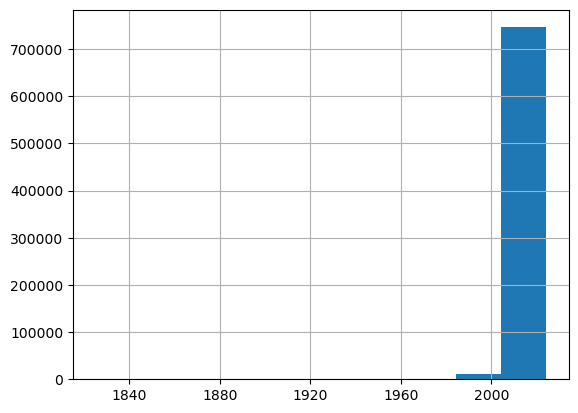

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Strukturerad datautvinning

Låt oss se vilken typ av information vi enkelt kan extrahera från sammanfattningar. En sak vi kanske är intresserade av är att se vilka behandlingsstrategier som finns och hur de har utvecklats över tid. Till att börja med kan vi manuellt sammanställa en lista över möjliga mediciner som används för att behandla COVID, samt en lista över diagnoser. Därefter går vi igenom dem och söker efter motsvarande termer i artiklarnas sammanfattningar.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Vi har lagt till flera kolumner i vår dataframe som innehåller antalet gånger en viss medicin/diagnos förekommer i abstraktet.

> **Observera** att vi lägger till ett mellanslag i början av ordet när vi letar efter en delsträng. Om vi inte gör det kan vi få felaktiga resultat, eftersom *klorokin* också skulle hittas inuti delsträngen *hydroxiklorokin*. Dessutom tvingar vi omvandling av kolumnen för abstrakt till `str` för att undvika ett fel - prova att ta bort `str` och se vad som händer.

För att göra det enklare att arbeta med data kan vi extrahera en delram som endast innehåller medicinräkningar och beräkna det ackumulerade antalet förekomster. Detta ger oss den mest populära medicinen:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

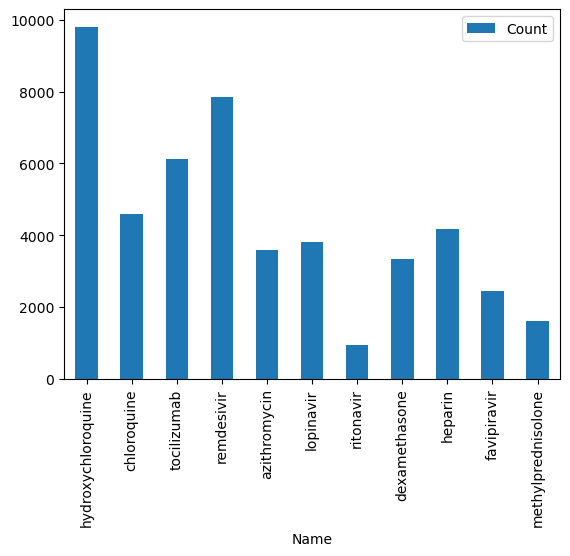

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Söker efter trender i behandlingsstrategi

I exemplet ovan har vi `sum`merat alla värden, men vi kan också göra samma sak på månadsbasis:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

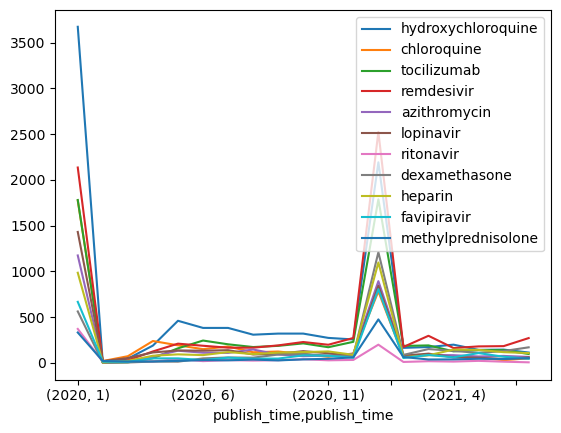

In [152]:
dfmt.plot()
plt.show()

En intressant observation är att vi har stora toppar på två platser: januari 2020 och januari 2021. Detta beror på att vissa artiklar inte har ett tydligt angivet publiceringsdatum, och de anges som januari för respektive år.

För att göra datan mer begriplig, låt oss visualisera bara några få läkemedel. Vi kommer också att "radera" data för januari och fylla i med något medelvärde, för att skapa en snyggare graf:


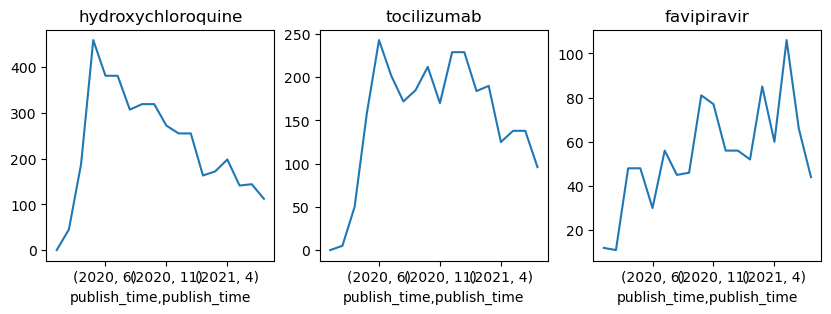

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

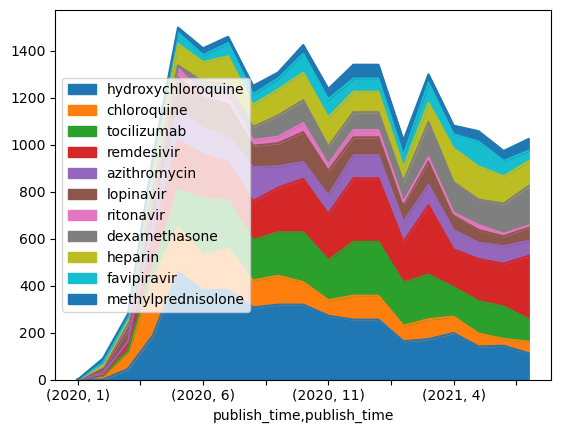

In [154]:
dfmt.plot.area()
plt.show()

Ännu längre kan vi beräkna relativ popularitet i procent:


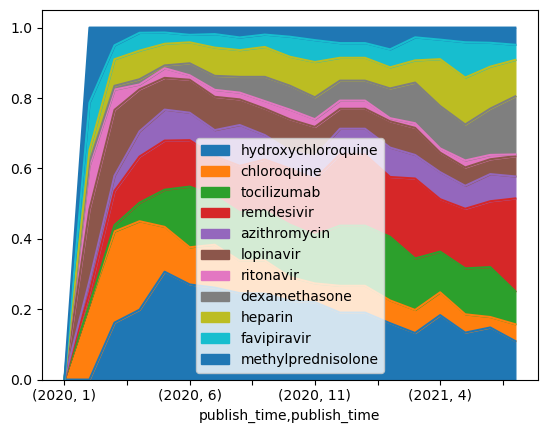

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Beräkning av samband mellan medicin och diagnos

En av de mest intressanta relationerna vi kan undersöka är hur olika diagnoser behandlas med olika mediciner. För att visualisera detta behöver vi beräkna en **samsynsfrekvenskarta**, som visar hur många gånger två termer nämns i samma artikel.

En sådan karta är i grunden en 2D-matris, som bäst representeras av en **numpy-array**. Vi kommer att beräkna denna karta genom att gå igenom alla abstrakt och markera de entiteter som förekommer där:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Ett sätt att visualisera denna matris är att rita en **värmekarta**:


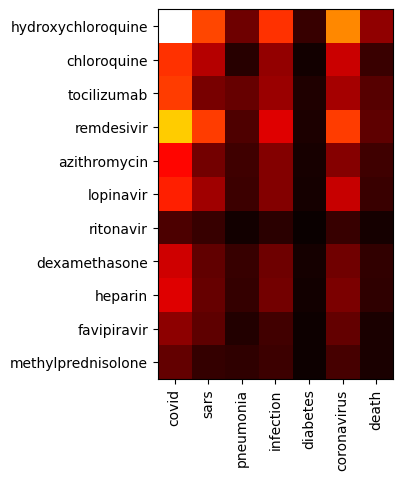

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Men ännu bättre visualisering kan göras med hjälp av den så kallade **Sankey**-diagrammet! `matplotlib` har inte inbyggt stöd för denna diagramtyp, så vi måste använda [Plotly](https://plotly.com/python/) enligt [denna handledning](https://plotly.com/python/sankey-diagram/).

För att skapa ett Sankey-diagram med Plotly behöver vi bygga följande listor:
* Listan `all_nodes` med alla noder i grafen, som kommer att inkludera både mediciner och diagnoser
* Listor över käll- och målindex - dessa listor visar vilka noder som går till vänster och vilka som går till höger i diagrammet
* Lista över alla länkar, där varje länk består av:
   - Källindex i `all_nodes`-arrayen
   - Målindex
   - Värde som anger styrkan på länken. Detta är exakt värdet från vår samförekomstmatris.
   - Valfritt färgval för länken. Vi kommer att göra det möjligt att markera vissa termer för tydlighetens skull.

Generisk kod för att rita Sankey-diagram är strukturerad som en separat `sankey`-funktion, som tar två listor (käll- och målgrupper) och en samförekomstmatris. Den gör det också möjligt att ange en tröskel och utesluta alla länkar som är svagare än den tröskeln - detta gör diagrammet lite mindre komplext.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Slutsats

Du har sett att vi kan använda ganska enkla metoder för att extrahera information från ostrukturerade datakällor, såsom text. I det här exemplet har vi använt den befintliga listan över mediciner, men det skulle vara mycket mer kraftfullt att använda tekniker för naturlig språkbehandling (NLP) för att utföra enhetsutvinning från text. I [detta blogginlägg](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) beskriver vi hur man använder molntjänster för enhetsutvinning. Ett annat alternativ skulle vara att använda Python NLP-bibliotek som [NLTK](https://www.nltk.org/) - en metod för att extrahera information från text med hjälp av NLTK beskrivs [här](https://www.nltk.org/book/ch07.html).


## Utmaning

Fortsätt att undersöka COVID-artikeldatan längs följande linjer:

1. Bygg en samförekomstmatris för olika mediciner och se vilka mediciner som ofta förekommer tillsammans (dvs. nämns i samma abstrakt). Du kan modifiera koden för att bygga en samförekomstmatris för mediciner och diagnoser.
1. Visualisera denna matris med hjälp av en värmekarta.
1. Som ett extra mål kan du visualisera samförekomsten av mediciner med hjälp av [chord-diagram](https://en.wikipedia.org/wiki/Chord_diagram). [Detta bibliotek](https://pypi.org/project/chord/) kan hjälpa dig att rita ett chord-diagram.
1. Som ytterligare ett extra mål, försök att extrahera doseringar av olika mediciner (såsom **400mg** i *ta 400mg klorokin dagligen*) med hjälp av reguljära uttryck, och bygg en dataframe som visar olika doseringar för olika mediciner. **Observera**: överväg numeriska värden som finns i nära textuell närhet till medicinens namn.



---

**Ansvarsfriskrivning**:  
Detta dokument har översatts med hjälp av AI-översättningstjänsten [Co-op Translator](https://github.com/Azure/co-op-translator). Även om vi strävar efter noggrannhet, vänligen notera att automatiska översättningar kan innehålla fel eller felaktigheter. Det ursprungliga dokumentet på dess originalspråk bör betraktas som den auktoritativa källan. För kritisk information rekommenderas professionell mänsklig översättning. Vi ansvarar inte för eventuella missförstånd eller feltolkningar som uppstår vid användning av denna översättning.
